In [1]:
import sys
sys.path.append("../model/robosat_pink/")
from robosat_pink import datasets
from robosat_pink.config import load_config

import os 
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

import pandas as pd
from pandas import Series

import boto3
import s3fs
from re import match
import tqdm
from itertools import chain
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import Env
from random import sample

from multiprocessing import Pool

import numpy as np

import ipywidgets as widgets

%matplotlib inline

## Clean Bad Tiles

We're having an issue where lots of image tiles have no data. Let's clean them up. 


In [76]:
tilefolder_re = "(.*)CO(.*)"
tile_re = ".*_.*\/\d*\/\d*\/\d*\.tif"

In [77]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name = 'esip'))
tileFolderCandidates = fs.ls('planet-snowcover-snow', update=True)

In [78]:
tileFolderCandidates

['planet-snowcover-snow/ASO_3M_SD_USCAJW_20180423.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCATE_20180423_binary.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20160404.geojson',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20160404.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20160404_binary.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330.geojson',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary.tif',
 'planet-snowcover-snow/ASO_3M_SD_USCAJW_20180423',
 'planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601',
 'planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles',
 'planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles_02',
 'planet-snowcover-snow/ASO_3M_SD_USCATE_20180423.tif?_ga=2.77458517.1128125195.1558820397-857243106_binary',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20160404_binary',
 'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary']

In [79]:
tileFolders = [f for f in tileFolderCandidates if match(tilefolder_re, f)]

In [80]:
allTiles = []
for folder in tqdm.tqdm(tileFolders, unit='folder'):
    allfiles = fs.walk(folder)
    tiles = [t for t in allfiles if match(tile_re, t)]
    allTiles.append(tiles)
allTiles = list(chain(*allTiles))

100%|██████████| 8/8 [00:00<00:00,  8.19folder/s]


In [82]:
snowTiles = allTiles

In [58]:
imageTiles = allTiles

In [29]:
snowTiles = allTiles

In [83]:
len(snowTiles), len(imageTiles)

(311, 563)

In [73]:
snowTileIds = ["/".join(t.split("/")[-3:]) for t in snowTiles]
imageTileIds = ["/".join(t.split("/")[-3:]) for t in imageTiles]

In [74]:
set(snowTileIds).intersection(imageTileIds)

{'15/5500/12712.tif',
 '15/5500/12713.tif',
 '15/5500/12714.tif',
 '15/5500/12723.tif',
 '15/5500/12724.tif',
 '15/5500/12725.tif',
 '15/5500/12726.tif',
 '15/5500/12727.tif',
 '15/5500/12728.tif',
 '15/5500/12729.tif',
 '15/5501/12704.tif',
 '15/5501/12705.tif',
 '15/5501/12706.tif',
 '15/5501/12707.tif',
 '15/5501/12708.tif',
 '15/5501/12709.tif',
 '15/5501/12710.tif',
 '15/5501/12711.tif',
 '15/5501/12712.tif',
 '15/5501/12713.tif',
 '15/5501/12714.tif',
 '15/5501/12723.tif',
 '15/5501/12724.tif',
 '15/5501/12725.tif',
 '15/5501/12726.tif',
 '15/5501/12727.tif',
 '15/5501/12728.tif',
 '15/5501/12729.tif',
 '15/5501/12730.tif',
 '15/5502/12703.tif',
 '15/5502/12704.tif',
 '15/5502/12705.tif',
 '15/5502/12706.tif',
 '15/5502/12708.tif',
 '15/5502/12709.tif',
 '15/5502/12710.tif',
 '15/5502/12711.tif',
 '15/5502/12712.tif',
 '15/5502/12713.tif',
 '15/5502/12714.tif',
 '15/5502/12723.tif',
 '15/5502/12724.tif',
 '15/5502/12725.tif',
 '15/5502/12726.tif',
 '15/5502/12727.tif',
 '15/5502/

---

In [86]:
def partialImageryTile(tilepath):
    with rio.Env(profile_name='esip'):
        try: 
            data = rio.open('s3://' + tilepath).read()
        except rio.errors.RasterioIOError as e:
            print(e)
            return False 
        
    flat = data.flatten()
    return flat.shape[0] != np.count_nonzero(flat)

def partialMaskTile(tilepath):
    with rio.Env(profile_name='esip'):
        try: 
            data = rio.open('s3://' + tilepath).read()
        except rio.errors.RasterioIOError as e:
            print(e)
            return False 
        
    flat = data.flatten()
    return flat.shape[0] != np.sum(flat >= 0)
    

        

In [87]:
len(allTiles)

1023

In [88]:
p = Pool(processes = 10)
result = p.map(partialMaskTile, allTiles)

In [89]:
allTilesArray = np.array(allTiles)
partialIndices = np.where(np.array(result) == True)[0]
partialTiles = allTilesArray[partialIndices]
len(partialTiles), len(allTiles)

(130, 1023)

In [91]:
partialTiles

array(['planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12514.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12515.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12516.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12517.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12518.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12519.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12520.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12521.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12522.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12523.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12524.tif',
       'planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary/15/6631/12525.tif',
    

In [97]:
def mvPartialTile(tile):
    base, ext = os.path.splitext(tile)
    newBase = base+'_partialtile'
    fs.mv(tile, newBase + ext)

In [98]:
errored = 0
for tile in tqdm.tqdm(partialTiles, unit='tile'):
    try: 
        mvPartialTile(tile)
    except Exception as e: 
        errored += 1
        continue
        
print(errored)

    

100%|██████████| 130/130 [00:20<00:00,  6.20tile/s]

0


In [30]:
partialTiles[0]

'planet-snowcover-imagery/20180330_172048_0f3f_3B_AnalyticMS_SR_clip/15/6631/12513.tif'

In [31]:
with rio.Env(profile_name='esip'):
    rio.open("s3://planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5526/12722_partialtile.tif").read()

## Examine Full Tiles

In [106]:
fullTiles = list(set(allTiles) - set(partialTiles))

In [115]:
tileSamp = sample(list(fullTiles), 5)

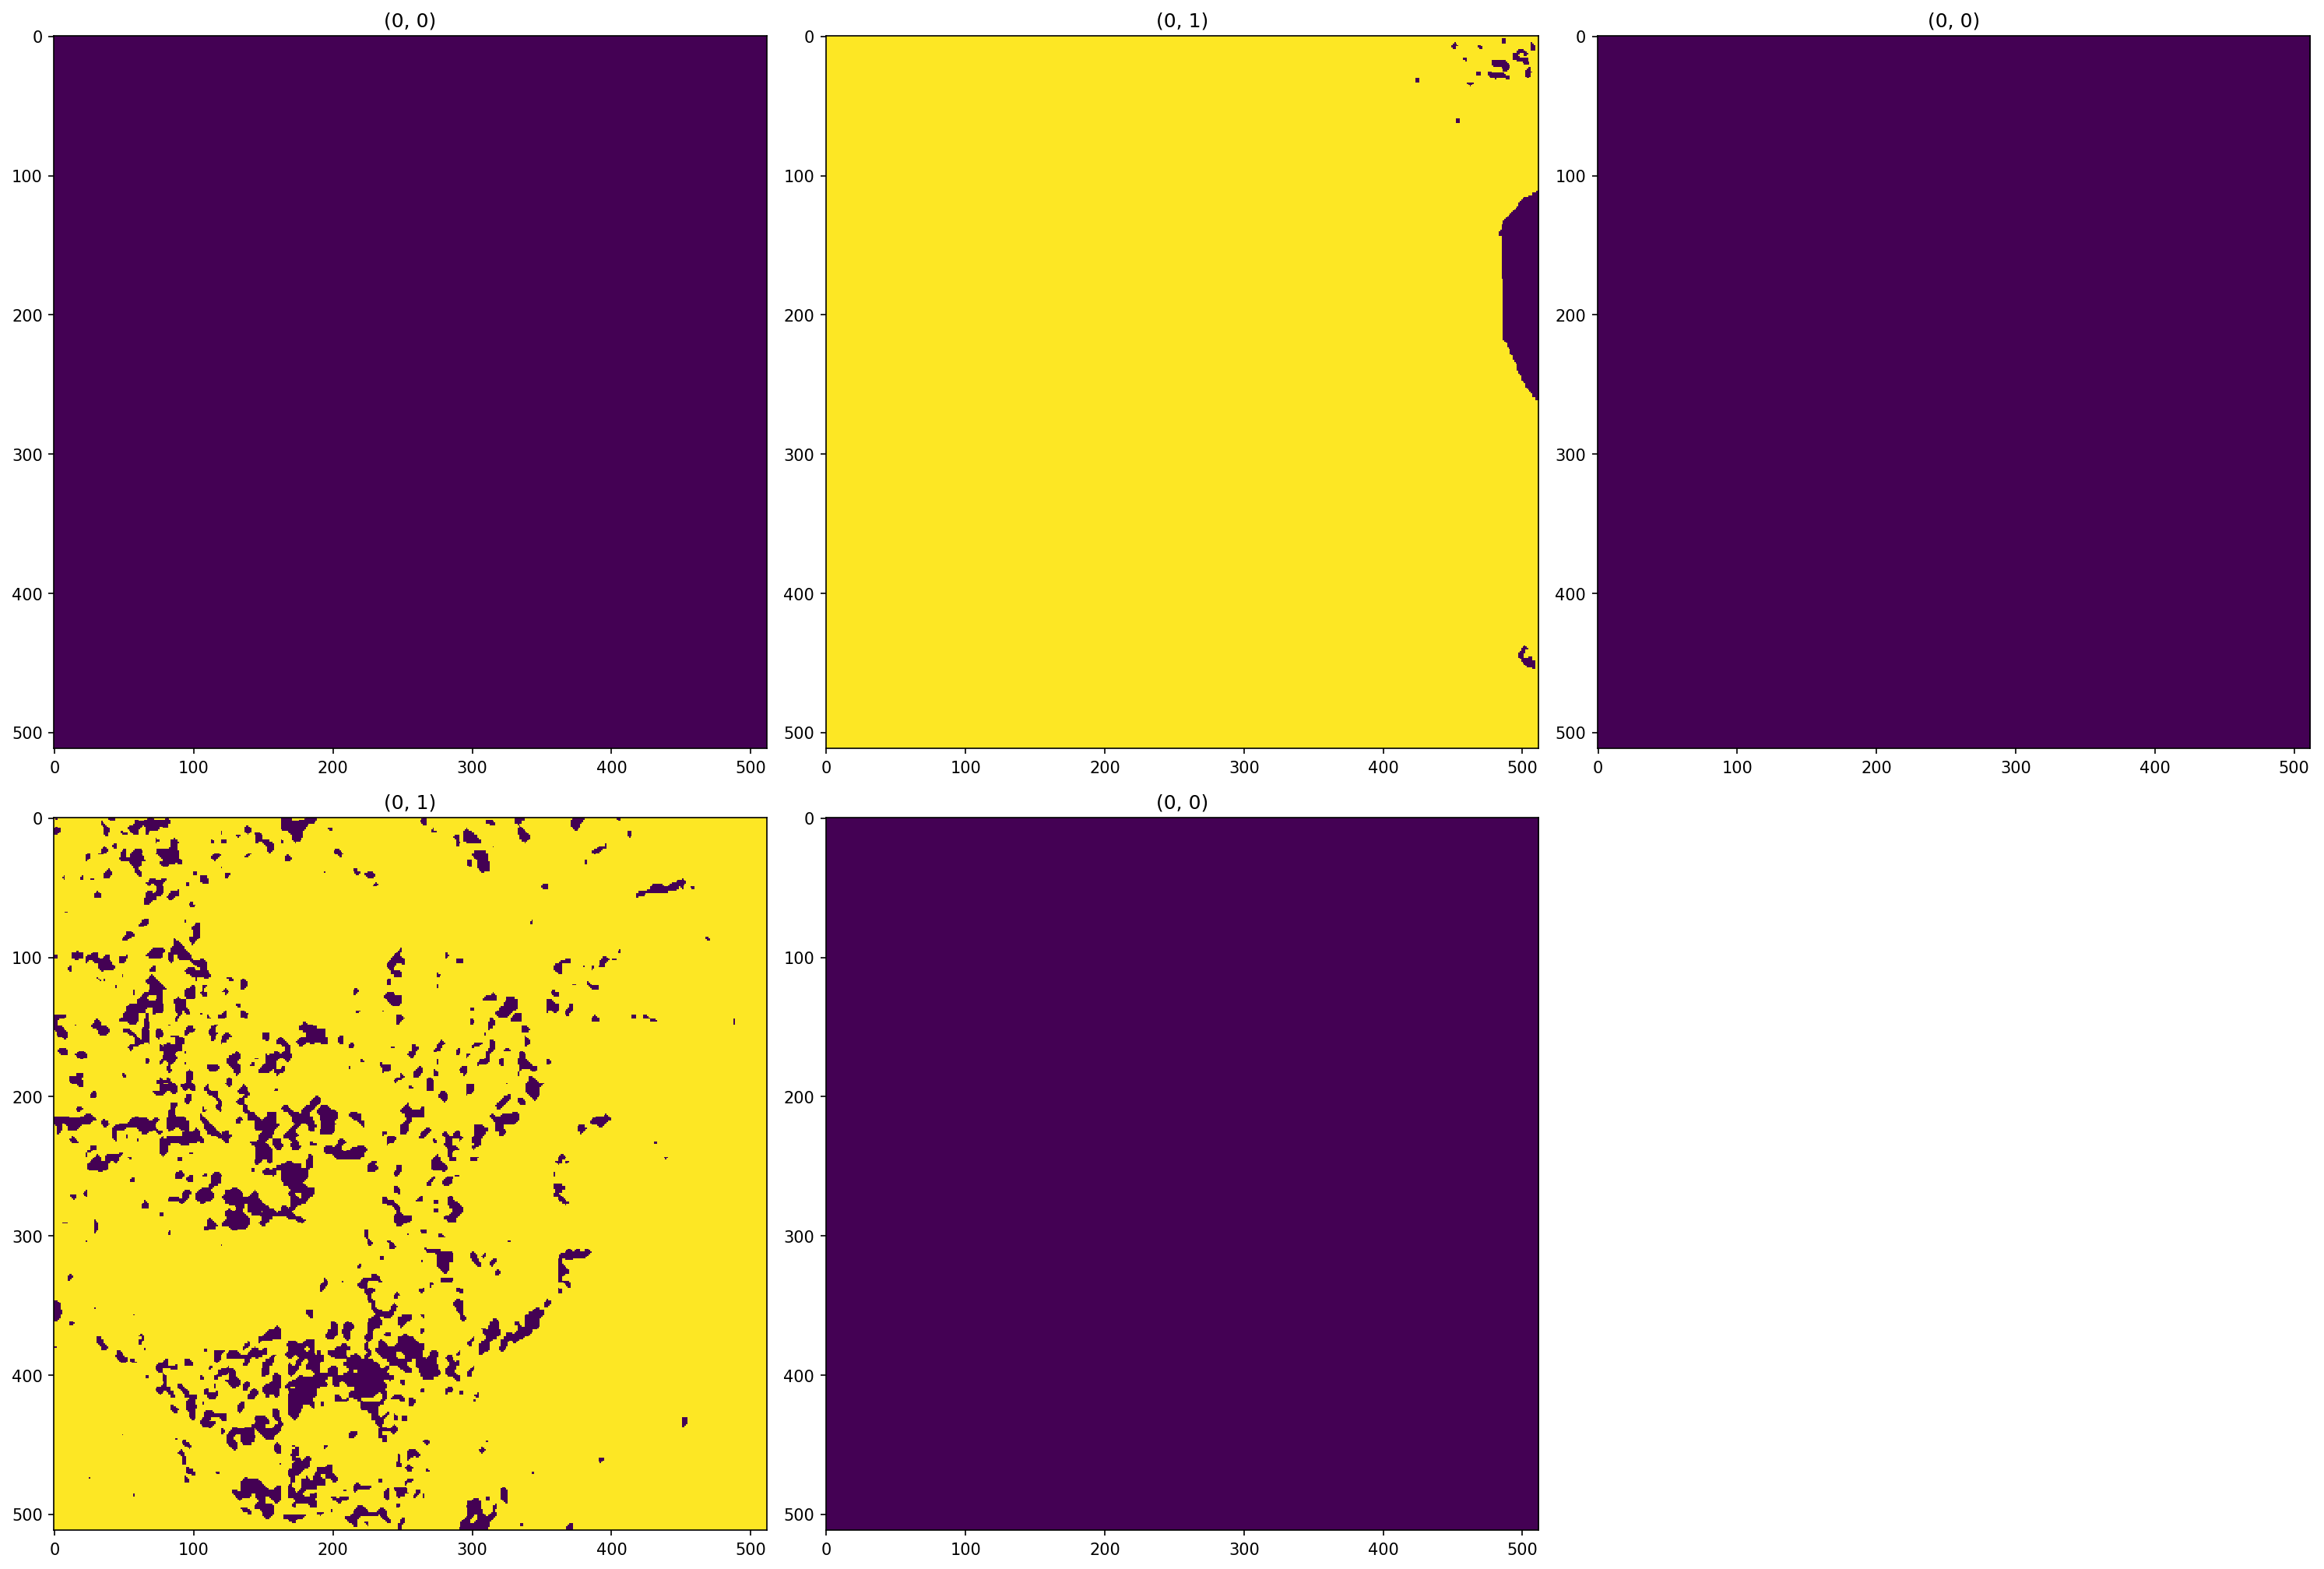

In [116]:
grid = plt.GridSpec(3, 3)
fig = plt.figure(figsize=(20,20), dpi = 150)
with rio.Env(profile_name="esip"):
    for i, tile in enumerate(tileSamp):
        t = rio.open("s3://" + tile)
        ax = plt.subplot(grid[i])
#         ax.imshow(np.moveaxis(np.stack([t.read(3), t.read(2), t.read(1)]), 0, -1))
        da = t.read(1)
        ax.imshow(da)
        ax.set_title((da.min(), da.max()))
plt.tight_layout()


---
# Diagnostics

In [104]:
# should have some partial tiles, we don't want 'em
tiledir = "planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled"
maskdir = "planet-snowcover-snow/ASO_3M_SD_USCAJW_20180423/ASO_3M_SD_USCAJW_20180423-MASK_02-COG"

In [102]:
from robosat_pink.datasets import MultiSlippyMapTilesConcatenation

In [105]:
mt = MultiSlippyMapTilesConcatenation([tiledir], [maskdir], aws_profile='esip')

In [112]:

partialTile('planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5540/12721.tif')

True

In [128]:
list(partialTiles.values)

['planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5526/12722.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5527/12720.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5527/12721.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5527/12722.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5528/12721.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5528/12722.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5529/12721.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5529/12722.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5530/12720.tif',
 'planet-snowcover-imagery/20180422_180809_1033_3B_AnalyticMS_SR_clip_tiled/15/5530/12721.tif',
 'planet-snowcover-imagery/20180422_1808